In [3]:
# PAQUETES PARA CORRER OP.
import pandas as pd
import numpy as np
import datetime as dt
import json
import wmf.wmf as wmf
import hydroeval
import glob
import MySQLdb
#modulo pa correr modelo
import SHop
import hidrologia

#FORMATO
# fuente
import matplotlib
matplotlib.use('Agg')
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager
font_dirs = ['/home/hidrologia/jupyter/SH_op/fuentes/AvenirLTStd-Book']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'Avenir LT Std'
matplotlib.rcParams['font.size']=12
import pylab as pl 
#axes
pl.rc('axes',labelcolor='#4f4f4f')
pl.rc('axes',linewidth=1.5)
pl.rc('axes',edgecolor='#bdb9b6')
pl.rc('text',color= '#4f4f4f')
# pl.rc('xtick',color='#4f4f4f')
# pl.rc('ytick',color='#4f4f4f')
# pl.locator_params(axis='y', nbins=5)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

<ipython-input-3-60b92a9e4a21>:23: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [4]:
# PAQUETES A CORRER EN PLANTILLA.
import matplotlib.pylab as pl 
%matplotlib inline

### Ejecución horaria.

Nota: Esta ejecución necesita que la ejecución diaria ya este configurada y generando resultados: CId

- Corre y grafica Qh

In [10]:
print (dt.datetime.now())

############################################################################################  ARGUMENTOS
#configfile horario
ruta_proj = '/home/hidrologia/jupyter/SH_op/SHop_E260_90m_1h/SHop/project_files/'
configfile=ruta_proj+'inputs/configfile_SHop_E260_90m_1h.md'
save_hist = True ###############################################################False for first times
date = '2020-11-28 22:13'#dt.datetime.now().strftime('%Y-%m-%d %H:%M')
ConfigList= SHop.get_rutesList(configfile)

#configfile diario
configfile_d=SHop.get_ruta(ConfigList,'ruta_md_d')
ConfigList_d= SHop.get_rutesList(configfile_d)

# abrir simubasin
path_ncbasin = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_nc')
cu = wmf.SimuBasin(rute=path_ncbasin)
#sets para correr modelo.
SHop.set_modelsettings(ConfigList)
warming_steps =  5*24#pasos de simulacion no seg, dependen del dt.
warming_window ='%ss'%int(wmf.models.dt * warming_steps) #siempre en seg
dateformat_starts = '%Y-%m-%d %H'
dateformat_binrain = '%Y%m%d%H%M'

#definicion de ventanas
starts  = ['%ss'%(0),'%ss'%(0)]
starts_names = ['1d','1d'] #starts y windows deben ser del mismo len.
window_end = '%ss'%(0*24*60*60) #hora actual

#definicion de executionprops
df_executionprops_h = pd.DataFrame([starts,
                                  starts_names,
                                  ['%s-p01-ci1-90d.StOhdr'%(SHop.get_ruta(ConfigList_d,'ruta_proj')+SHop.get_ruta(ConfigList_d,'ruta_sto_op')),
                                  'reglas_pant'],
                                  ['ci2','ci3'],
                                  #[1.0 , 5.9 , 5.7 , 0.0 , 1.0 , 1.0 , 10.8 , 1.0 , 1.0 , 1.0 ],
                                  [[0.8 , 10 , 17.7 , 0.0 , 9.0 , 2.0 , 15 , 0.9 , 1.0 , 1.0, 1.0 ],
                                   [0.8 , 10 , 17.7 , 0.0 , 9.0 , 2.0 , 15 , 0.9 , 1.0 , 1.0, 1.0 ]],
#                                    [0.8,  8.5, 13,    0.0,  9.0,  2.0,   4,     1,    1,    1,  1]
                                  ['-p01','-p01'],
                                  [0,0]], #pasos de sim, depende de dt
                                 columns = [1,2],
                                 index = ['starts','start_names','CIs','CI_names','pars','pars_names','wup_steps']).T

print ('#########################')
print ('Start HOURLY execution: %s'%dt.datetime.now())    
#ventanas de tiempo en que se correra


#dates
start_o = pd.to_datetime(pd.to_datetime(date).strftime('%Y-%m-%d')) - pd.Timedelta('2d')#arranca desde las 00 del dia anterior para tener 1d de calentamiento.

starts_w_h = [start_o - pd.Timedelta(start) for start in starts]
starts_m_h = [start_w_h - pd.Timedelta(warming_window) for start_w_h in starts_w_h]
end_h = pd.to_datetime(pd.to_datetime(date).strftime(dateformat_starts)) + pd.Timedelta(window_end)


# rainfall  : takes 3min
pseries,ruta_out_rain_h = SHop.get_rainfall2sim(ConfigList,cu,path_ncbasin,[starts_m_h[0]],end_h, #se corre el bin mas largo.
                                             Dt= float(wmf.models.dt),include_escenarios=None,
                                             evs_hist= False,
                                             check_file=True,stepback_start = '%ss'%int(wmf.models.dt*1),
                                             complete_naninaccum=True,verbose=False)

print (ruta_out_rain_h)

SHop.set_modelsettings(ConfigList)
# set of executions
ListEjecs_h =  SHop.get_executionlists_fromdf(ConfigList,ruta_out_rain_h,cu,starts_m_h,end_h,df_executionprops_h,
                                         warming_steps=warming_steps, dateformat_starts = dateformat_starts,
                                         path_pant4rules = ruta_out_rain_h)

# #execution
print ('Start simulations: %s'%dt.datetime.now())
print ('start: %s - end: %s'%(starts_m_h[0], end_h))
SHop.set_modelsettings(ConfigList)
res = SHop.get_qsim(ListEjecs_h[:],set_CI=True,save_hist=save_hist,verbose = True)
print ('End simulations: %s'%dt.datetime.now())

2021-02-01 12:59:00.375976
#########################
Start HOURLY execution: 2021-02-01 12:59:00.463286
/home/hidrologia/jupyter/SH_op/SHop_E260_90m_1h/SHop/project_files/results/results_op/rain_op/202011202300_202011282200-SHop_E260_90m_1h.bin
Start simulations: 2021-02-01 12:59:00.482252
start: 2020-11-21 00:00:00 - end: 2020-11-28 22:00:00
Config. -p01ci2-1d ejecutado
Config. -p01ci3-1d ejecutado
End simulations: 2021-02-01 12:59:05.016617


In [8]:
print('hourly execution takes: %s seg.'%(2.5*60.))

hourly execution takes: 120.0 seg.


In [11]:
#REVISAR CAUDAL.
#tramos, para sacar los datos del modelo.
df_tramos = pd.read_csv(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_nc_tramos'),index_col=0)
ests = df_tramos.index
#curvas que escogí.
df_est_features = pd.read_csv(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_curvascalob3'),index_col=0)
ests = df_est_features.index
tramos_ids = np.concatenate(df_tramos.loc[ests].values)
df_est_features['tramo'] = list(map(str,tramos_ids))

#df con metadatos de estaciones
#METADATOS BD
server,user,passwd,dbname = SHop.get_credentials(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_credenciales'))

conn_db = MySQLdb.connect(server,user,passwd,dbname)
db_cursor = conn_db.cursor ()
query = 'select codigo,nombreestacion,longitude,latitude,estado from estaciones where codigo in ("%s","%s","%s","%s","%s","%s","%s","%s","%s");'%(ests[0],ests[1],ests[2],ests[3],ests[4],ests[5],ests[6],ests[7],ests[8])#,"%s","%s","%s","%s"

db_cursor.execute (query)
data = db_cursor.fetchall()
conn_db.close()
fields = [field.lower() for field in list(np.array(db_cursor.description)[:,0])]
df_bd = pd.DataFrame(np.array(data), columns = fields)
df_bd['codigo'] = list(map(int,df_bd['codigo']))
df_bd = df_bd.set_index('codigo')

#OTROS ARGS
start = starts_w_h[0]
end= end_h
Dt = '1h'
colors_d = ['lightgreen','g']#['c','darkblue']#
ylims = [10,40,40,100,300,200,300]

path_r = ruta_out_rain_h.split('.')[0]+'.hdr'
path_masks_csv = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_csv_subbasinmask')

rutafig = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_qsim_png')

print ('Start graphics: %s'%dt.datetime.now())
#GRAFICA
SHop.plot_Q(start,end,Dt,server,user,passwd,dbname,
            ListEjecs_h,cu,ests,colors_d,path_r,path_masks_csv,
            df_bd,df_est_features,ylims,rutafig=rutafig)
print ('End graphics: %s'%dt.datetime.now())

SERVER_CON: Succesful connection to Sal
Graphics are generated.


---

#### Revisar
- revisar los intermedios y que se actualicen correctamente los archivo historicos, que tienen ultima edicion el 22 de ago.
- pasar a función para sacar caudal.

In [12]:
#REVISAR CAUDAL.
#tramos, para sacar los datos del modelo.
df_tramos = pd.read_csv(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_nc_tramos'),index_col=0)
ests = df_tramos.index
#curvas que escogí.
df_est_features = pd.read_csv(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_curvascalob3'),index_col=0)
ests = df_est_features.index
tramos_ids = np.concatenate(df_tramos.loc[ests].values)
df_est_features['tramo'] = list(map(str,tramos_ids))

In [13]:
ListEjecs_h

[[<wmf.wmf.SimuBasin at 0x7f71dda11940>,
  'ci2',
  array([[2.8050000e+02, 2.8050000e+02, 2.8050000e+02, ..., 4.1489999e+02,
          4.1489999e+02, 4.8591667e+01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
          0.0000000e+00, 0.0000000e+00],
         [1.2891123e+00, 8.4649920e-01, 3.1415772e-01, ..., 4.3120492e-01,
          8.7539506e-01, 4.1846158e+02],
         [3.1673691e+01, 2.8855221e+01, 2.7446735e+01, ..., 1.8915449e+01,
          2.8331781e+01, 1.7259819e+03],
         [6.0000005e-03, 6.0000005e-03, 6.0000005e-03, ..., 6.0000005e-03,
          6.0000005e-03, 1.6343750e+01]], dtype=float32),
  '/home/hidrologia/jupyter/SH_op/SHop_E260_90m_1h/SHop/project_files/results/results_op/rain_op/202011202300_202011282200-SHop_E260_90m_1h.bin',
  '-p01',
  [0.8, 10, 17.7, 0.0, 9.0, 2.0, 15, 0.9, 1.0, 1.0, 1.0],
  191,
  0,
  '1d',
  '/home/hidrologia/jupyter/SH_op/SHop_E260_90m_1h/SHop/project_files/results/results_op/Sto_op-p01-ci2-1d',
  '/home/h

In [14]:
dflol = pd.read_csv(ListEjecs_h[0][-4],index_col=0,parse_dates=True)

In [15]:
dflol

,912,911,910,909,908,907,904,903,900,899,...,10,5,4,9,8,7,6,3,2,1
2020-11-26 00:00:00,0.0,2.588675e-09,4.049124e-10,1.278143e-11,1.695017e-08,4.221923e-09,0.000229,0.000375,0.000234,0.012937,...,52.642666,0.000589,0.021360,0.017860,52.680440,52.849340,0.026946,52.933700,0.034514,53.194557
2020-11-26 01:00:00,0.0,2.233190e-09,3.528411e-10,1.105543e-11,1.459313e-08,3.686519e-09,0.000216,0.000347,0.000215,0.012090,...,52.485767,0.000556,0.020648,0.017040,52.523434,52.691430,0.026744,52.775482,0.033412,53.034893
2020-11-26 02:00:00,0.0,1.928625e-09,3.079512e-10,9.582069e-12,1.257359e-08,3.222993e-09,0.000203,0.000321,0.000197,0.011282,...,52.393944,0.000525,0.019959,0.016256,52.431477,52.598557,0.026545,52.682260,0.032344,52.940235
2020-11-26 03:00:00,0.0,1.667461e-09,2.691995e-10,8.322221e-12,1.084227e-08,2.821275e-09,0.000191,0.000297,0.000180,0.010514,...,52.240463,0.000496,0.019290,0.015505,52.277930,52.444286,0.026347,52.527770,0.031308,52.784480
2020-11-26 04:00:00,0.0,1.443317e-09,2.357002e-10,7.243079e-12,9.357170e-09,2.472752e-09,0.000180,0.000275,0.000164,0.009785,...,52.059906,0.000468,0.018642,0.014787,52.097300,52.262913,0.026151,52.346150,0.030303,52.601593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-28 18:00:00,0.0,4.218238e-02,8.779257e-02,1.461455e-02,2.022644e-01,7.792246e-02,0.002430,0.006377,0.141420,0.205856,...,88.233284,0.000013,0.001934,0.000928,88.274790,88.438780,0.016563,88.521450,0.003991,88.752655
2020-11-28 19:00:00,0.0,4.061078e-02,8.744102e-02,1.429127e-02,2.053636e-01,7.475828e-02,0.002331,0.005992,0.142220,0.198892,...,87.246650,0.000012,0.001861,0.000910,87.281075,87.431145,0.016442,87.501850,0.003869,87.719950
2020-11-28 20:00:00,0.0,3.865065e-02,8.524692e-02,1.364420e-02,2.051131e-01,7.054561e-02,0.002232,0.005622,0.141598,0.191110,...,86.948814,0.006051,0.034457,0.002481,86.982810,87.133690,0.016464,87.204220,0.043371,87.461136
2020-11-28 21:00:00,0.0,3.647068e-02,8.176917e-02,1.280099e-02,2.022229e-01,6.577642e-02,0.002133,0.005266,0.139899,0.182753,...,89.017630,0.016321,0.106586,0.015581,89.060560,89.229904,0.028704,89.319460,0.145657,89.688290


<AxesSubplot:>

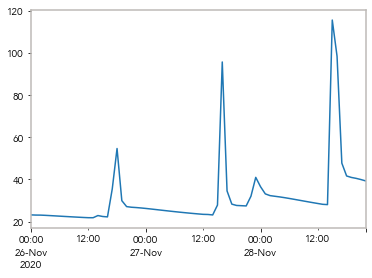

In [16]:
est = 99
dflol['2020']['%s'%(df_est_features.tramo.loc[est])].plot() #3d

In [17]:
dflol.index

DatetimeIndex(['2020-11-26 00:00:00', '2020-11-26 01:00:00',
               '2020-11-26 02:00:00', '2020-11-26 03:00:00',
               '2020-11-26 04:00:00', '2020-11-26 05:00:00',
               '2020-11-26 06:00:00', '2020-11-26 07:00:00',
               '2020-11-26 08:00:00', '2020-11-26 09:00:00',
               '2020-11-26 10:00:00', '2020-11-26 11:00:00',
               '2020-11-26 12:00:00', '2020-11-26 13:00:00',
               '2020-11-26 14:00:00', '2020-11-26 15:00:00',
               '2020-11-26 16:00:00', '2020-11-26 17:00:00',
               '2020-11-26 18:00:00', '2020-11-26 19:00:00',
               '2020-11-26 20:00:00', '2020-11-26 21:00:00',
               '2020-11-26 22:00:00', '2020-11-26 23:00:00',
               '2020-11-27 00:00:00', '2020-11-27 01:00:00',
               '2020-11-27 02:00:00', '2020-11-27 03:00:00',
               '2020-11-27 04:00:00', '2020-11-27 05:00:00',
               '2020-11-27 06:00:00', '2020-11-27 07:00:00',
               '2020-11-

#### Revisar binhumedad.

In [18]:
f=open(ListEjecs_h[0][-5]+'.StOhdr')
filelines=f.readlines()
f.close()
IDs=np.array([int(i.split(',')[0]) for i in filelines[5:]])

In [19]:
v,r = wmf.models.read_float_basin_ncol(ListEjecs_h[0][-5]+'.StObin',100, cu.ncells, 5)

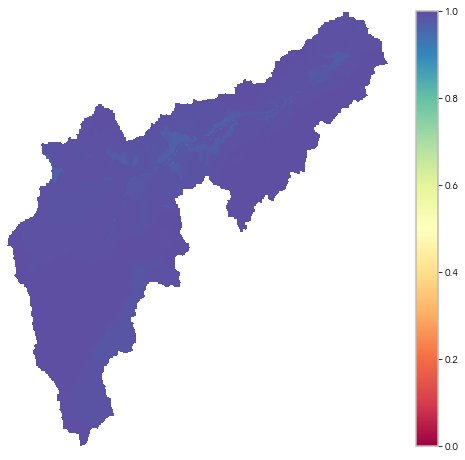

([-75.71068572998047, -75.2148112343857, 5.983959197998047, 6.550444326363504],
 <AxesSubplot:>)

In [20]:
cu.Plot_basinClean(v[0]/wmf.models.max_capilar,show_cbar=True)

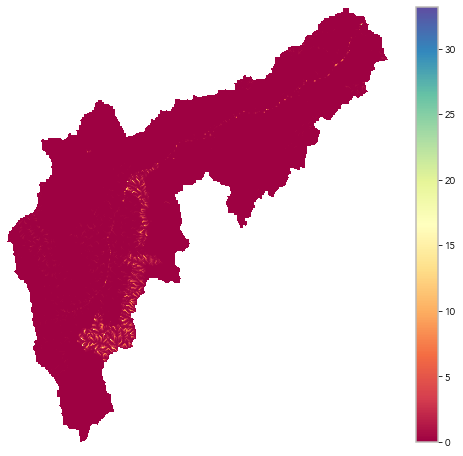

([-75.71068572998047, -75.2148112343857, 5.983959197998047, 6.550444326363504],
 <AxesSubplot:>)

In [21]:
cu.Plot_basinClean(v[2]/wmf.models.max_capilar,show_cbar=True)

-----

-----

-----